# Reinforcement Learning II: $Q$-learning


In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In the first reinforcment lab we learned how to find the best value-state function $V^*$ for a given Markov decision process (MDP). In real world problems specifing a complet MDP is often not possible due to unknown or infinite (or at least very big) state space. In such cases Monte Carlo methods can be used to learn $Q$ directly.

In this lab we will investigate Q-learning and how to deal with an unknown state space. Therfore we define a class which stores q values in a lookup table.

In [2]:
class QValues(object):
    
    def __init__(self):
        '''Initialize with empty lookup table.'''
        self.values = {}
        
    def get_value(self, state, action):
        '''Return stored q value for (state, action) pair or a random number if unknown.'''
        if not state in self.values:
            self.values[state] = {}
        if not action in self.values[state]:
            self.values[state][action] = abs(np.random.randn()) + 1
        return self.values[state][action]
    
    def set_value(self, state, action, value):
        '''Stored q value for (state, action) pair.'''
        if not state in self.values:
            self.values[state] = {}
        if not action in self.values[state]:
            self.values[state][action] = 0
        
        self.values[state][action] = value
    
    def max_action(self, state, actions, learning=True):
        '''Return the action with highest q value for given state and action list.'''
        if not learning and not state in self.values:
            return actions[0] if actions else None
        
        max_value = -np.inf
        max_action = actions[0] if actions else None
        for action in actions:
            if not learning and not action in self.values[state]:
                continue

            value = self.get_value(state, action)
            if value > max_value:
                max_value = value
                max_action = action
            elif value == max_value and learning:
                max_action = np.random.choice([max_action, action])
        return max_action
    
    def epsilon_greedy(self, state, actions, epsilon):
        '''Returns max_action or random action with probability of epsilon.'''
        if np.random.rand() < epsilon:
            return np.random.choice(actions)
        return self.max_action(state, actions)
    
    def __str__(self):
        nr_states = len(self.values.keys())
        return 'Number of states: {}'.format(nr_states)

We can now add $(state, action)$ pairs to $Q$ and request pairs we haven’t set yet (which get initialised randomly).

In [3]:
q = QValues()
q.set_value(0, 'down', 1.2)
q.set_value(0, 'left', 0.5)
print('Q(0, "left") = {}'.format(q.get_value(0, 'left')))
print('Q(1, "up") = {}'.format(q.get_value(1, 'up')))
print(q.values)

Q(0, "left") = 0.5
Q(1, "up") = 1.86257030614
{0: {'down': 1.2, 'left': 0.5}, 1: {'up': 1.8625703061395276}}


We can also request the action with the highest q value in a given state $s$ for a list of actions. For the Monte Carlo approch we can also request the action with the highest q value with an $\epsilon$ chance of getting a random action.

In [4]:
print('Max action in state 0: {}'.format(q.max_action(0, ['down', 'left'])))
for _ in range(5):
    print('epsilon_greedy in state 0: {}'.format(q.epsilon_greedy(0, ['down', 'left'], epsilon=1.)))


Max action in state 0: down
epsilon_greedy in state 0: left
epsilon_greedy in state 0: down
epsilon_greedy in state 0: down
epsilon_greedy in state 0: left
epsilon_greedy in state 0: left


Instead of an MDP we model the world as an environment. It holds the current state (e.g. coordinates of a robot) and defines the allowed actions in the current state (e.g. according to the current coordinates "drive left" or "drive ahead"). It allows the execution of an action and returns the next state and the reward for the action. Compare this definition to the definition in the lecture slides (page 9).

In [5]:
class Environment(object):

    def __init__(self):
        '''Initialise  environment.'''
        pass
    
    def reset(self):
        '''Reset environment to initial state.'''
        pass
   
    def get_state(self):
        '''Return current state.'''
        pass
    
    def get_actions(self):
        '''Return all allowed actions as list (might be empty).'''
        pass

    def exceute(self, action):
        '''Set internal state to the new state according to action and return (new_state, reward) tuple.'''
        pass

The following code is just a helper function to display a grid world example.

In [6]:
def draw_gridworld(env, path=[]):
    plt.plot()
    plt.xlim(-1, 2)
    plt.ylim(3, -1)
    plt.grid()
    plt.xticks([0,1])
    plt.yticks([0,1,2])
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])

    plt.annotate('goal ' + str(env.goal), (env.goal[0]+0.25, env.goal[1]+0.5))
    plt.annotate('start' + str(env.start), (env.start[0]+0.25, env.start[1]+0.5))        
    for (x1, y1), (x2, y2) in env.walls:
        if x1 == x2:
            plt.plot([x1, x1+1],[max(y1,y2), max(y1,y2)], c='k')
        else:
            plt.plot([max(x1,x2), max(x1,x2)], [min(y1, y2), min(y1, y2)+1], c='k')
    for (x,y), action in path:
        plt.scatter(x+0.5, y+0.5, s=100, c='blue', marker={'left': '<', 'right':'>','up':'^', 'down':'v'}[action])

Lets define a grid word example as environment. We have a start, goal and current position. Each position is given in (x,y)-coordinates. The get_actions method allows 'left', 'right', 'up' and 'down' in any position except the final one. The reward for each action is -1. See how we can generate and infinit state space by just walking endless in one direction.

In [7]:
class GridWorld(Environment):

    def __init__(self):
        self.start = (0, 0)
        self.goal = (0, 1)
        self.position = (0, 0)
        self.walls = []
    
    def reset(self):
        self.position = self.start

    def get_state(self):
        return self.position
    
    def get_actions(self):
        return [] if self.position == self.goal else ['left', 'right', 'up', 'down']
        
    def exceute(self, action):
        position = self.get_state()
        move = {'left':(-1,0), 'right':(1,0), 'up':(0,-1), 'down':(0,1)}[action]
        self.position = (position[0] + move[0], position[1] + move[1])

        reward = -1.
        return self.position, reward
    
    def draw(self, path=[]):
        draw_gridworld(self, path)

For visualisation we display only the states around the start and goal.

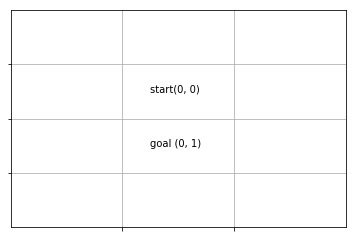

In [8]:
GridWorld().draw()

The following code shows how $Q$-learning can be implemented. Our implementation will use the environment to read the current state, get the possible actions and get the reward after choosing an action.

#### Q-learning Algorithm:

Initialize $Q(s,a)$ arbitrarily<br>
Repeat (for each episode):<br>
&nbsp;&nbsp;&nbsp;&nbsp;Initialize $s$<br>
&nbsp;&nbsp;&nbsp;&nbsp;Repeat (for each step of episode):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Choose $a$ from $s$ using policy derived from $Q$ by $\epsilon$-greedy<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Take action $a$, observe $r, s'$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$Q(s,a) \leftarrow Q(s,a) + \alpha [r+ \gamma $max$_{a'}Q(s',a')-Q(s,a)]$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$s \leftarrow s'$<br>
&nbsp;&nbsp;&nbsp;&nbsp;until $s$ terminal<br>
Output $Q$

In [9]:
def q_learning(env, q=None, nr_episodes=100, nr_steps=100, epsilon=0.1, alpha=0.1, gamma=0.98):
    if not q:
        q = QValues()

    for _ in range(nr_episodes):
        env.reset()
        for _ in range(nr_steps):
            state = env.get_state()
            actions = env.get_actions()
            if not actions:
                break # final state reached

            action = q.epsilon_greedy(state, actions, epsilon)
            q_old = q.get_value(state, action)
            
            _, reward = env.exceute(action) #take action
            next_state = env.get_state()
            next_max_action = q.max_action(next_state, env.get_actions())
            q_next = q.get_value(next_state, next_max_action)
            
            q_new = q_old + alpha * (reward + gamma * q_next - q_old)
            q.set_value(state, action, q_new)
    return q

We can now use the algorithm to derive $Q$ for the grid word example. From $Q$ we can get an optimal path by always choosing the actions with the highest expected reward.

(0, 0) down -> (0, 1)


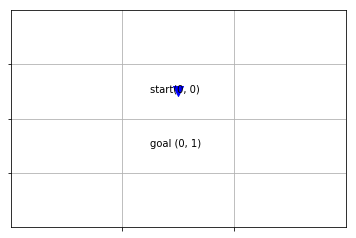

In [10]:
env = GridWorld()
q = q_learning(env, nr_episodes=100, nr_steps=100)

env.reset()
best_path = []
for _ in range (10):
    state = env.get_state()
    actions = env.get_actions()
    if not actions:
        break # final state reached

    action = q.max_action(state, actions, learning=False)
    next_state, _ = env.exceute(action)
    print('{} {} -> {}'.format(state, action, next_state))

    best_path.append((state, action))
    
env.draw(best_path)

As expected it was learned that the best state-action value from the initial state is down to the final state. Notice that during learning much more states where visited due to $\epsilon$-greedy policy.

In [11]:
print(q)

Number of states: 353


#### Exercise

Lets create a new grid world environment by defining two walls (one between start and goal and one between goal and the field right to goal). Rewrite the execute method in such way that a an action that would cause a movement through a wall results in saying in the current position (state). The reward should be -1 in any case.

In [12]:
class GridWorld2(GridWorld):

    def __init__(self):
        self.start = (0, 0)
        self.goal = (0, 1)
        self.position = (0, 0)
        self.walls = [((0, 0), (0, 1)), # wall from (0,0) to (0,1)
                      ((0, 1), (1, 1))] # wall from (0,1) to (1,1)
            
    def exceute(self, action):
        position = self.get_state()
        if (position == (0, 0) and action == 'down') or (position == (1, 1) and action == 'left'):
            return position, -1
        else:
            move = {'left':(-1,0), 'right':(1,0), 'up':(0,-1), 'down':(0,1)}[action]
            self.position = (position[0] + move[0], position[1] + move[1])

            reward = -1.
            return self.position, reward

When the code was implemented correct the optimal path found should be:

Position,  Action -> Next Position <br>
(0, 0),    left   -> (-1, 0)<br>
(-1, 0),   down   -> (-1, 1)<br>
(-1, 1),   right  -> (0, 1)<br>

(0, 0) left -> (-1, 0)
(-1, 0) down -> (-1, 1)
(-1, 1) right -> (0, 1)


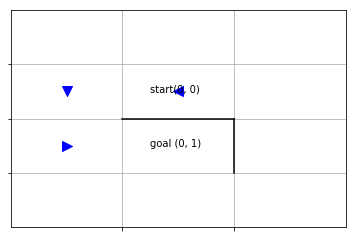

In [13]:
env = GridWorld2()
q = q_learning(env, nr_episodes=500, nr_steps=100, epsilon=0.1, alpha=0.1, gamma=0.98)

env.reset()
best_path = []
for _ in range (10):
    state = env.get_state()
    actions = env.get_actions()
    if not actions:
        break # final state reached

    action = q.max_action(state, actions, learning=False)
    next_state, _ = env.exceute(action)
    print('{} {} -> {}'.format(state, action, next_state))

    best_path.append((state, action))
    
env.draw(best_path)

#### Question

When lowering the nr_episodes (e.g. 50) in the above example the found path may not be optimal or leading to the final state at all. What are the reason for this behaviour?

#### Answer

- $Q$-Learning does not guarantee to result in $Q^*$
- too few episodes or steps might result in never reaching the final state
- find good balance between exploration and exploitation
- init values for $Q$ should be chosen with respoect to the rewards (here random negative instead of positive)

Instead of implementing $Q$ as lookup table, one can use a neuronal network. Think about possible implementations and how the training would change. One possible solution will be presented in the exercise.